# Distribution of NO<sub>2</sub> by CAMS and TROPOMI

### Main goal

Show side by side the total columns of NO<sub>2</sub> from CAMS and TROPOMI datasets.

### Selected period and study area
* Period: 21/06/2021 between 00:00:00 and 18:00:00
* Location: Czech Republic

### TODO
* Add apriori data to calculate component column 

## Imports and supporting functions

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

In [2]:
%run functions.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define study area

In [4]:
# Define limit latitudes and longitudes
lat_min = 48.5
lat_max = 51.1
lon_min = 12
lon_max = 18.9

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

## 2. Define datasets

In [5]:
# Define component
component = 'nitrogen_dioxide'
component_nom = 'NO2'
component_mol_weight = 46.005 #g/mol

# CAMS: Define period
start_date = '2021-06-21'
end_date = '2021-06-21'

# TROPOMI: Define file and product name
file_name = 'd762cc7a-f037-4fb8-bc04-cac8e7f39f5b'
product_name = 'S5P_NRTI_L2__NO2____20210621T124026_20210621T124526_19112_01_010400_20210621T132518.nc'

## 3. CAMS data

### Collect and read data as xarray

In [6]:
#CAMS_download(start_date, end_date, component, component_nom)
CAMS_ds = CAMS_read(start_date, end_date, component, component_nom)
CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 4)
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-07-21T22:06 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [7]:
# Read csv table with 137 levels
CAMS_levels = pd.read_csv('data/ads/137-levels.csv')

# Drop first row and set n as index hybrid
CAMS_levels = CAMS_levels.drop(0).reset_index(drop = True)
CAMS_levels = CAMS_levels.set_index('n')
CAMS_levels.index.names = ['hybrid']

# Change important columns to numeric
CAMS_levels['pf [hPa]'] = pd.to_numeric(CAMS_levels['pf [hPa]'])
CAMS_levels['Geopotential Altitude [m]'] = pd.to_numeric(CAMS_levels['Geopotential Altitude [m]'])
CAMS_levels['Density [kg/m^3]'] = pd.to_numeric(CAMS_levels['Density [kg/m^3]'])

# Calculate difference from geopotential altitude
CAMS_levels['Depth [m]'] = CAMS_levels['Geopotential Altitude [m]'].diff(-1)

# Add layer depth to last row manually
CAMS_levels['Depth [m]'].iloc[-1] = CAMS_levels['Geopotential Altitude [m]'].iloc[-1]

CAMS_levels

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],Depth [m]
hybrid,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,2320.96
...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,22.96


### Reduce data to study area

In [8]:
# Get nearest longitude and latitude to bbox
lon_min_index = nearest_neighbour(CAMS_ds.longitude.data, bbox[0][0])
lon_max_index = nearest_neighbour(CAMS_ds.longitude.data, bbox[1][0])
lat_min_index = nearest_neighbour(CAMS_ds.latitude.data, bbox[0][1])
lat_max_index = nearest_neighbour(CAMS_ds.latitude.data, bbox[1][1])

# Define slices
slice_lat = slice(lat_min_index, lat_max_index + 1)
slice_lon = slice(lon_min_index, lon_max_index + 1)

# Set limits
CAMS_ds = CAMS_ds.isel(longitude = slice_lon, latitude = slice_lat)

CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 4)
Coordinates:
    time        datetime64[ns] 2021-06-21
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] 2021-06-21 ... 2021-06-21T18:00:00
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-07-21T22:06 GRIB to CDM+CF via cfgrib-0.9.9...

## 4. TROPOMI data

### Collect and read data as xarray

In [9]:
#TROPOMI_download(file_name, component_nom)
TROPOMI_ds = TROPOMI_read(product_name, component_nom)
TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

### Calculate pressure

In [10]:
# Read support data to calculate pressure
support_ds = xr.open_dataset('data/tropomi/' + component_nom + '/' + product_name, group = 'PRODUCT/SUPPORT_DATA/INPUT_DATA')

# Calculate pressure as p = ap + b * ps
p = TROPOMI_ds.tm5_constant_a + TROPOMI_ds.tm5_constant_b * support_ds.surface_pressure / 100
TROPOMI_ds = TROPOMI_ds.assign(pressure = p)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/13)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...

### Reduce data to study area

In [11]:
"""
# Create dataframe with scanlines and ground pixels
TROPOMI_df = []
TROPOMI_df = pd.DataFrame(list(product(TROPOMI_ds.ground_pixel.values, TROPOMI_ds.scanline.values)), 
                          columns = ['ground_pixel', 'scanline'])

# Find corresponding latitudes and longitudes                          
for index, row in TROPOMI_df.iterrows():
    TROPOMI_df.loc[index,'latitude'] = TROPOMI_ds.latitude.sel(
                                        scanline = TROPOMI_df['scanline'].loc[index], 
                                        ground_pixel = TROPOMI_df['ground_pixel'].loc[index]).values
                                        
    TROPOMI_df.loc[index,'longitude'] = TROPOMI_ds.longitude.sel(
                                        scanline = TROPOMI_df['scanline'].loc[index], 
                                        ground_pixel = TROPOMI_df['ground_pixel'].loc[index]).values

# Save as csv
TROPOMI_df.to_csv('data/tropomi/TROPOMI_df_' + product_name + '1' + '.csv', index = False)
"""

"\n# Create dataframe with scanlines and ground pixels\nTROPOMI_df = []\nTROPOMI_df = pd.DataFrame(list(product(TROPOMI_ds.ground_pixel.values, TROPOMI_ds.scanline.values)), \n                          columns = ['ground_pixel', 'scanline'])\n\n# Find corresponding latitudes and longitudes                          \nfor index, row in TROPOMI_df.iterrows():\n    TROPOMI_df.loc[index,'latitude'] = TROPOMI_ds.latitude.sel(\n                                        scanline = TROPOMI_df['scanline'].loc[index], \n                                        ground_pixel = TROPOMI_df['ground_pixel'].loc[index]).values\n                                        \n    TROPOMI_df.loc[index,'longitude'] = TROPOMI_ds.longitude.sel(\n                                        scanline = TROPOMI_df['scanline'].loc[index], \n                                        ground_pixel = TROPOMI_df['ground_pixel'].loc[index]).values\n\n# Save as csv\nTROPOMI_df.to_csv('data/tropomi/TROPOMI_df_' + product_name + '1' + '

In [12]:
# Read csv
TROPOMI_df = pd.read_csv('data/tropomi/TROPOMI_df_' + product_name + '1' + '.csv')

# Set limits
TROPOMI_df = TROPOMI_df[(TROPOMI_df['latitude'] >= lat_min) & (TROPOMI_df['latitude'] <= lat_max)]
TROPOMI_df = TROPOMI_df[(TROPOMI_df['longitude'] >= lon_min) & (TROPOMI_df['longitude'] <= lon_max)]

TROPOMI_df

,ground_pixel,scanline,latitude,longitude
144534,387.0,183.0,48.546898,12.072847
144535,387.0,184.0,48.595726,12.062323
144536,387.0,185.0,48.644573,12.051785
144537,387.0,186.0,48.693401,12.041157
144538,387.0,187.0,48.742229,12.030693
...,...,...,...,...
164355,440.0,235.0,50.872116,18.894257
164356,440.0,236.0,50.920200,18.891136
164357,440.0,237.0,50.968403,18.888002
164358,440.0,238.0,51.016579,18.885010


In [13]:
# Get nearest longitude and latitude to bbox
gp_min_index = nearest_neighbour(TROPOMI_ds.ground_pixel.data, np.min(TROPOMI_df['ground_pixel']))
gp_max_index = nearest_neighbour(TROPOMI_ds.ground_pixel.data, np.max(TROPOMI_df['ground_pixel']))
sl_min_index = nearest_neighbour(TROPOMI_ds.scanline.data, np.min(TROPOMI_df['scanline']))
sl_max_index = nearest_neighbour(TROPOMI_ds.scanline.data, np.max(TROPOMI_df['scanline']))

# Define slices
slice_gp = slice(gp_min_index, gp_max_index)
slice_sl = slice(sl_min_index, sl_max_index)

# Set limits
TROPOMI_ds = TROPOMI_ds.isel(ground_pixel = slice_gp, scanline = slice_sl)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 53, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 57, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/13)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...

### Calculate column averaging kernels

In [14]:
kernel_column_da = xr.where(TROPOMI_ds.layer > TROPOMI_ds.tm5_tropopause_layer_index, 0, 
                            TROPOMI_ds.averaging_kernel * (TROPOMI_ds.air_mass_factor_total / 
                            TROPOMI_ds.air_mass_factor_troposphere))

TROPOMI_ds = TROPOMI_ds.assign(kernel_column = kernel_column_da)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 53, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 57, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...
    kernel_column                                         (layer, time, scanline, ground_pixel) float32 ...

## 5. Apply averaging kernels

### Linear interpolation of CAMS data to 100x100

In [15]:
#CAMS_ds_new =  CAMS_interpolation(CAMS_ds, TROPOMI_ds, lon_min, lon_max, lat_min, lat_max, component_nom)

### Convert units (kg/kg to molecules/cm<sup>2</sup>)

In [16]:
# Create xarray object from levels df
CAMS_levels_ds = CAMS_levels.to_xarray()

# From kg/kg to kg/m3
CAMS_ds = CAMS_ds * CAMS_levels_ds['Density [kg/m^3]']

# From kg/m3 to kg/m2
CAMS_ds = CAMS_ds * CAMS_levels_ds['Depth [m]']

# From kg/m2 to molecules/cm2
NA = 6.022*10**23
CAMS_ds = (CAMS_ds * NA * 1000) / (10000 * component_mol_weight)

CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 4)
Coordinates:
    time        datetime64[ns] 2021-06-21
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] 2021-06-21 ... 2021-06-21T18:00:00
Data variables:
    component   (step, hybrid, latitude, longitude) float64 4.048e+11 ... 9.2...

### Transform TROPOMI ds into df

In [17]:
TROPOMI_df = TROPOMI_ds.to_dataframe()

In [18]:
TROPOMI_df = TROPOMI_df.drop(columns=['nitrogendioxide_tropospheric_column_precision', 
                                      'nitrogendioxide_tropospheric_column_precision_kernel',
                                      'averaging_kernel',
                                      'air_mass_factor_troposphere',
                                      'air_mass_factor_total',
                                      'tm5_tropopause_layer_index',
                                      'tm5_constant_a',
                                      'tm5_constant_b',
                                      'time_utc'])

TROPOMI_df = TROPOMI_df.droplevel(['corner', 'intensity_offset_polynomial_exponents', 'polynomial_exponents']).drop_duplicates()
TROPOMI_df = TROPOMI_df.groupby(by = ['layer', 'ground_pixel', 'scanline', 'time', 'delta_time']).mean()
TROPOMI_df = TROPOMI_df.reset_index(level = 'delta_time')
TROPOMI_df

delta_time   latitude  \
layer ground_pixel scanline time                                            
0.0   387.0        182.0    2021-06-21 2021-06-21 12:42:53.473  48.498062   
                   183.0    2021-06-21 2021-06-21 12:42:54.312  48.546898   
                   184.0    2021-06-21 2021-06-21 12:42:55.152  48.595726   
                   185.0    2021-06-21 2021-06-21 12:42:55.992  48.644573   
                   186.0    2021-06-21 2021-06-21 12:42:56.832  48.693401   
...                                                        ...        ...   
33.0  439.0        234.0    2021-06-21 2021-06-21 12:43:37.151  50.831364   
                   235.0    2021-06-21 2021-06-21 12:43:37.991  50.879574   
                   236.0    2021-06-21 2021-06-21 12:43:38.831  50.927681   
                   237.0    2021-06-21 2021-06-21 12:43:39.671  50.975895   
                   238.0    2021-06-21 2021-06-21 12:43:40.511  51.024086   

                                        longitude  qa_value  TROPOMI_column  \
layer ground_pixel scanline time                                              
0.0   387.0        182.0    2021-06-21  12.083351      1.00        0.000034   
                   183.0    2021-06-21  12.072847      1.00        0.000037   
                   184.0    2021-06-21  12.062323      1.00        0.000017   
                   185.0    2021-06-21  12.051785      1.00        0.000021   
                   186.0    2021-06-21  12.041157      1.00        0.000036   
...                                           ...       ...             ...   
33.0  439.0        234.0    2021-06-21  18.782627      0.74        0.000039   
                   235.0    2021-06-21  18.779318      1.00        0.000040   
                   236.0    2021-06-21  18.776081      1.00        0.000042   
                   237.0    2021-06-21  18.772829      1.00        0.000028   
                   238.0    2021-06-21  18.769716      1.00        0.000044   

                                          pressure  kernel_column  
layer ground_pixel scanline time                                   
0.0   387.0        182.0    2021-06-21  965.634521       0.247081  
                   183.0    2021-06-21  967.995117       0.260220  
                   184.0    2021-06-21  963.876160       0.242474  
                   185.0    2021-06-21  962.294189       0.229287  
                   186.0    2021-06-21  963.231873       0.232694  
...                                            ...            ...  
33.0  439.0        234.0    2021-06-21    0.000000       0.000000  
                   235.0    2021-06-21    0.000000       0.000000  
                   236.0    2021-06-21    0.000000       0.000000  
                   237.0    2021-06-21    0.000000       0.000000  
                   238.0    2021-06-21    0.000000       0.000000  

[102714 rows x 7 columns]

### Convert units (mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [19]:
TROPOMI_df['TROPOMI_column'] = TROPOMI_df['TROPOMI_column'] * 6.02214*10**19

### Pass NaNs to data with qa_value under 0.5

In [20]:
TROPOMI_df.loc[TROPOMI_df['qa_value'] < 0.5, ['TROPOMI_column', 'kernel_column']] = float('NaN')

### Combine data (nearest neighbours)

In [21]:
match_df = TROPOMI_df

CAMS_latitudes = CAMS_ds.latitude.data
CAMS_longitudes = CAMS_ds.longitude.data
CAMS_pressures = CAMS_levels['pf [hPa]'].to_numpy()
CAMS_times = CAMS_ds.valid_time.data

match_df['lat_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_latitudes, row['latitude']), axis = 1)
match_df['lon_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_longitudes, row['longitude']), axis = 1)
match_df['lay_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_pressures, row['pressure']), axis = 1)
match_df['step_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_times, row['delta_time']), axis = 1)
match_df['CAMS_time'] = match_df.apply(lambda row: CAMS_ds.valid_time[row['step_index']].values, axis = 1)

match_df['CAMS_component'] = match_df.apply(lambda row: CAMS_ds.component.isel(hybrid = int(row['lay_index']) - 1, 
                        latitude = int(row['lat_index']), longitude = int(row['lon_index']), step = int(row['step_index'])).values, axis = 1)

match_df

delta_time   latitude  \
layer ground_pixel scanline time                                            
0.0   387.0        182.0    2021-06-21 2021-06-21 12:42:53.473  48.498062   
                   183.0    2021-06-21 2021-06-21 12:42:54.312  48.546898   
                   184.0    2021-06-21 2021-06-21 12:42:55.152  48.595726   
                   185.0    2021-06-21 2021-06-21 12:42:55.992  48.644573   
                   186.0    2021-06-21 2021-06-21 12:42:56.832  48.693401   
...                                                        ...        ...   
33.0  439.0        234.0    2021-06-21 2021-06-21 12:43:37.151  50.831364   
                   235.0    2021-06-21 2021-06-21 12:43:37.991  50.879574   
                   236.0    2021-06-21 2021-06-21 12:43:38.831  50.927681   
                   237.0    2021-06-21 2021-06-21 12:43:39.671  50.975895   
                   238.0    2021-06-21 2021-06-21 12:43:40.511  51.024086   

                                        longitude  qa_value  TROPOMI_column  \
layer ground_pixel scanline time                                              
0.0   387.0        182.0    2021-06-21  12.083351      1.00    2.028193e+15   
                   183.0    2021-06-21  12.072847      1.00    2.228453e+15   
                   184.0    2021-06-21  12.062323      1.00    1.051446e+15   
                   185.0    2021-06-21  12.051785      1.00    1.280466e+15   
                   186.0    2021-06-21  12.041157      1.00    2.157828e+15   
...                                           ...       ...             ...   
33.0  439.0        234.0    2021-06-21  18.782627      0.74    2.336574e+15   
                   235.0    2021-06-21  18.779318      1.00    2.379105e+15   
                   236.0    2021-06-21  18.776081      1.00    2.526104e+15   
                   237.0    2021-06-21  18.772829      1.00    1.665865e+15   
                   238.0    2021-06-21  18.769716      1.00    2.666097e+15   

                                          pressure  kernel_column  lat_index  \
layer ground_pixel scanline time                                               
0.0   387.0        182.0    2021-06-21  965.634521       0.247081          0   
                   183.0    2021-06-21  967.995117       0.260220          0   
                   184.0    2021-06-21  963.876160       0.242474          0   
                   185.0    2021-06-21  962.294189       0.229287          1   
                   186.0    2021-06-21  963.231873       0.232694          1   
...                                            ...            ...        ...   
33.0  439.0        234.0    2021-06-21    0.000000       0.000000          6   
                   235.0    2021-06-21    0.000000       0.000000          6   
                   236.0    2021-06-21    0.000000       0.000000          6   
                   237.0    2021-06-21    0.000000       0.000000          6   
                   238.0    2021-06-21    0.000000       0.000000          7   

                                        lon_index  lay_index  step_index  \
layer ground_pixel scanline time                                           
0.0   387.0        182.0    2021-06-21          0        125           2   
                   183.0    2021-06-21          0        125           2   
                   184.0    2021-06-21          0        124           2   
                   185.0    2021-06-21          0        124           2   
                   186.0    2021-06-21          0        124           2   
...                                           ...        ...         ...   
33.0  439.0        234.0    2021-06-21         17          0           2   
                   235.0    2021-06-21         17          0           2   
                   236.0    2021-06-21         17          0           2   
                   237.0    2021-06-21         17          0           2   
                   238.0    2021-06-21         17          0         

### Calculate CAMS columns

In [22]:
# Calculate values to generate CAMS column to sum in the next step
match_df['CAMS_column'] = match_df.apply(lambda row: row['CAMS_component'] * 
                                                     row['kernel_column'], 
                                                     axis = 1)

match_df

delta_time   latitude  \
layer ground_pixel scanline time                                            
0.0   387.0        182.0    2021-06-21 2021-06-21 12:42:53.473  48.498062   
                   183.0    2021-06-21 2021-06-21 12:42:54.312  48.546898   
                   184.0    2021-06-21 2021-06-21 12:42:55.152  48.595726   
                   185.0    2021-06-21 2021-06-21 12:42:55.992  48.644573   
                   186.0    2021-06-21 2021-06-21 12:42:56.832  48.693401   
...                                                        ...        ...   
33.0  439.0        234.0    2021-06-21 2021-06-21 12:43:37.151  50.831364   
                   235.0    2021-06-21 2021-06-21 12:43:37.991  50.879574   
                   236.0    2021-06-21 2021-06-21 12:43:38.831  50.927681   
                   237.0    2021-06-21 2021-06-21 12:43:39.671  50.975895   
                   238.0    2021-06-21 2021-06-21 12:43:40.511  51.024086   

                                        longitude  qa_value  TROPOMI_column  \
layer ground_pixel scanline time                                              
0.0   387.0        182.0    2021-06-21  12.083351      1.00    2.028193e+15   
                   183.0    2021-06-21  12.072847      1.00    2.228453e+15   
                   184.0    2021-06-21  12.062323      1.00    1.051446e+15   
                   185.0    2021-06-21  12.051785      1.00    1.280466e+15   
                   186.0    2021-06-21  12.041157      1.00    2.157828e+15   
...                                           ...       ...             ...   
33.0  439.0        234.0    2021-06-21  18.782627      0.74    2.336574e+15   
                   235.0    2021-06-21  18.779318      1.00    2.379105e+15   
                   236.0    2021-06-21  18.776081      1.00    2.526104e+15   
                   237.0    2021-06-21  18.772829      1.00    1.665865e+15   
                   238.0    2021-06-21  18.769716      1.00    2.666097e+15   

                                          pressure  kernel_column  lat_index  \
layer ground_pixel scanline time                                               
0.0   387.0        182.0    2021-06-21  965.634521       0.247081          0   
                   183.0    2021-06-21  967.995117       0.260220          0   
                   184.0    2021-06-21  963.876160       0.242474          0   
                   185.0    2021-06-21  962.294189       0.229287          1   
                   186.0    2021-06-21  963.231873       0.232694          1   
...                                            ...            ...        ...   
33.0  439.0        234.0    2021-06-21    0.000000       0.000000          6   
                   235.0    2021-06-21    0.000000       0.000000          6   
                   236.0    2021-06-21    0.000000       0.000000          6   
                   237.0    2021-06-21    0.000000       0.000000          6   
                   238.0    2021-06-21    0.000000       0.000000          7   

                                        lon_index  lay_index  step_index  \
layer ground_pixel scanline time                                           
0.0   387.0        182.0    2021-06-21          0        125           2   
                   183.0    2021-06-21          0        125           2   
                   184.0    2021-06-21          0        124           2   
                   185.0    2021-06-21          0        124           2   
                   186.0    2021-06-21          0        124           2   
...                                           ...        ...         ...   
33.0  439.0        234.0    2021-06-21         17          0           2   
                   235.0    2021-06-21         17          0           2   
                   236.0    2021-06-21         17          0           2   
                   237.0    2021-06-21         17          0           2   
                   238.0    2021-06-21         17          0         

In [23]:
match_ds = match_df.to_xarray()
match_ds

<xarray.Dataset>
Dimensions:         (ground_pixel: 53, layer: 34, scanline: 57, time: 1)
Coordinates:
  * layer           (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 30.0 31.0 32.0 33.0
  * ground_pixel    (ground_pixel) float64 387.0 388.0 389.0 ... 438.0 439.0
  * scanline        (scanline) float64 182.0 183.0 184.0 ... 236.0 237.0 238.0
  * time            (time) datetime64[ns] 2021-06-21
Data variables: (12/14)
    delta_time      (layer, ground_pixel, scanline, time) datetime64[ns] 2021...
    latitude        (layer, ground_pixel, scanline, time) float32 48.5 ... 51.02
    longitude       (layer, ground_pixel, scanline, time) float32 12.08 ... 1...
    qa_value        (layer, ground_pixel, scanline, time) float32 1.0 ... 1.0
    TROPOMI_column  (layer, ground_pixel, scanline, time) float64 2.028e+15 ....
    pressure        (layer, ground_pixel, scanline, time) float32 965.6 ... 0.0
    ...              ...
    lon_index       (layer, ground_pixel, scanline, time) int64 0 0 0 ... 17 17
    lay_index       (layer, ground_pixel, scanline, time) int64 125 125 ... 0 0
    step_index      (layer, ground_pixel, scanline, time) int64 2 2 2 ... 2 2 2
    CAMS_time       (layer, ground_pixel, scanline, time) datetime64[ns] 2021...
    CAMS_component  (layer, ground_pixel, scanline, time) object 568187636113...
    CAMS_column     (layer, ground_pixel, scanline, time) float64 1.404e+13 ....

In [24]:
# Read latitudes, longituds and CAMS time from data array
latitude = match_ds.latitude.mean(dim = 'layer')
longitude = match_ds.longitude.mean(dim = 'layer')
CAMS_time = match_ds.CAMS_time.mean(dim = 'layer')

In [25]:
# Get sum of CAMS data of each layer to get column data
CAMS = match_ds.CAMS_column.sum(dim = 'layer', skipna = False)
CAMS = CAMS.assign_coords(latitude = latitude, longitude = longitude, 
                          CAMS_time = CAMS_time)
CAMS

<xarray.DataArray 'CAMS_column' (ground_pixel: 53, scanline: 57, time: 1)>
array([[[7.48624612e+14],
        [7.58951363e+14],
        [7.52938717e+14],
        ...,
        [6.79845864e+14],
        [6.84728546e+14],
        [6.83147134e+14]],

       [[7.44343150e+14],
        [7.50385421e+14],
        [7.48274308e+14],
        ...,
        [6.85563206e+14],
        [6.88632723e+14],
        [6.80763833e+14]],

       [[4.37205664e+14],
        [4.39296255e+14],
        [4.37634352e+14],
        ...,
...
        ...,
        [1.15605881e+15],
        [1.13875361e+15],
        [6.90525792e+14]],

       [[2.74332494e+14],
        [2.73101985e+14],
        [2.70668513e+14],
        ...,
        [1.10867073e+15],
        [1.05289981e+15],
        [8.03843345e+14]],

       [[2.80030475e+14],
        [2.76291211e+14],
        [2.70923788e+14],
        ...,
        [1.07248724e+15],
        [1.06021607e+15],
        [7.90235059e+14]]])
Coordinates:
  * ground_pixel  (ground_pixel) float64 387.0 388.0 389.0 ... 437.0 438.0 439.0
  * scanline      (scanline) float64 182.0 183.0 184.0 ... 236.0 237.0 238.0
  * time          (time) datetime64[ns] 2021-06-21
    latitude      (ground_pixel, scanline, time) float32 48.5 48.55 ... 51.02
    longitude     (ground_pixel, scanline, time) float32 12.08 12.07 ... 18.77
    CAMS_time     (ground_pixel, scanline, time) datetime64[ns] 2021-06-21T12...

In [26]:
# Get mean of TROPOMI data of each layer (it must be equal)
TROPOMI = match_ds.TROPOMI_column.mean(dim = 'layer', skipna = False)
TROPOMI = TROPOMI.assign_coords(latitude = latitude, longitude = longitude)
TROPOMI

<xarray.DataArray 'TROPOMI_column' (ground_pixel: 53, scanline: 57, time: 1)>
array([[[2.02819298e+15],
        [2.22845279e+15],
        [1.05144602e+15],
        ...,
        [1.90383784e+15],
        [5.07239347e+14],
        [1.08164495e+15]],

       [[1.71451335e+15],
        [2.73555022e+15],
        [1.96068140e+15],
        ...,
        [1.87590587e+15],
        [1.09923472e+15],
        [1.22188343e+15]],

       [[1.93141430e+15],
        [2.09747668e+15],
        [1.97075773e+15],
        ...,
...
        ...,
        [1.57344723e+15],
        [2.47980846e+15],
        [1.62909972e+15]],

       [[1.45532656e+15],
        [1.99942064e+15],
        [2.14389423e+15],
        ...,
        [3.02055967e+15],
        [1.49555126e+15],
        [2.01081129e+15]],

       [[1.10716654e+15],
        [1.86558042e+15],
        [2.01104864e+15],
        ...,
        [2.52610422e+15],
        [1.66586498e+15],
        [2.66609743e+15]]])
Coordinates:
  * ground_pixel  (ground_pixel) float64 387.0 388.0 389.0 ... 437.0 438.0 439.0
  * scanline      (scanline) float64 182.0 183.0 184.0 ... 236.0 237.0 238.0
  * time          (time) datetime64[ns] 2021-06-21
    latitude      (ground_pixel, scanline, time) float32 48.5 48.55 ... 51.02
    longitude     (ground_pixel, scanline, time) float32 12.08 12.07 ... 18.77

## 6. Merge data

In [30]:
merged_ds = xr.merge([CAMS, TROPOMI])
merged_ds

<xarray.Dataset>
Dimensions:         (ground_pixel: 53, scanline: 57, time: 1)
Coordinates:
  * ground_pixel    (ground_pixel) float64 387.0 388.0 389.0 ... 438.0 439.0
  * scanline        (scanline) float64 182.0 183.0 184.0 ... 236.0 237.0 238.0
  * time            (time) datetime64[ns] 2021-06-21
    latitude        (ground_pixel, scanline, time) float32 48.5 48.55 ... 51.02
    longitude       (ground_pixel, scanline, time) float32 12.08 12.07 ... 18.77
    CAMS_time       (ground_pixel, scanline, time) datetime64[ns] 2021-06-21T...
Data variables:
    CAMS_column     (ground_pixel, scanline, time) float64 7.486e+14 ... 7.90...
    TROPOMI_column  (ground_pixel, scanline, time) float64 2.028e+15 ... 2.66...

In [31]:
merged_df = merged_ds.to_dataframe()
merged_df

latitude  longitude           CAMS_time  \
ground_pixel scanline time                                                   
387.0        182.0    2021-06-21  48.498051  12.083346 2021-06-21 12:00:00   
             183.0    2021-06-21  48.546886  12.072846 2021-06-21 12:00:00   
             184.0    2021-06-21  48.595715  12.062320 2021-06-21 12:00:00   
             185.0    2021-06-21  48.644562  12.051787 2021-06-21 12:00:00   
             186.0    2021-06-21  48.693390  12.041160 2021-06-21 12:00:00   
...                                     ...        ...                 ...   
439.0        234.0    2021-06-21  50.831387  18.782631 2021-06-21 12:00:00   
             235.0    2021-06-21  50.879551  18.779316 2021-06-21 12:00:00   
             236.0    2021-06-21  50.927700  18.776081 2021-06-21 12:00:00   
             237.0    2021-06-21  50.975918  18.772829 2021-06-21 12:00:00   
             238.0    2021-06-21  51.024078  18.769716 2021-06-21 12:00:00   

                                   CAMS_column  TROPOMI_column  
ground_pixel scanline time                                      
387.0        182.0    2021-06-21  7.486246e+14    2.028193e+15  
             183.0    2021-06-21  7.589514e+14    2.228453e+15  
             184.0    2021-06-21  7.529387e+14    1.051446e+15  
             185.0    2021-06-21  4.900653e+14    1.280466e+15  
             186.0    2021-06-21  4.857535e+14    2.157828e+15  
...                                        ...             ...  
439.0        234.0    2021-06-21  1.201964e+15    2.336574e+15  
             235.0    2021-06-21  1.130051e+15    2.379105e+15  
             236.0    2021-06-21  1.072487e+15    2.526104e+15  
             237.0    2021-06-21  1.060216e+15    1.665865e+15  
             238.0    2021-06-21  7.902351e+14    2.666097e+15  

[3021 rows x 5 columns]

## 7. Visualize data

/home/avc/.local/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


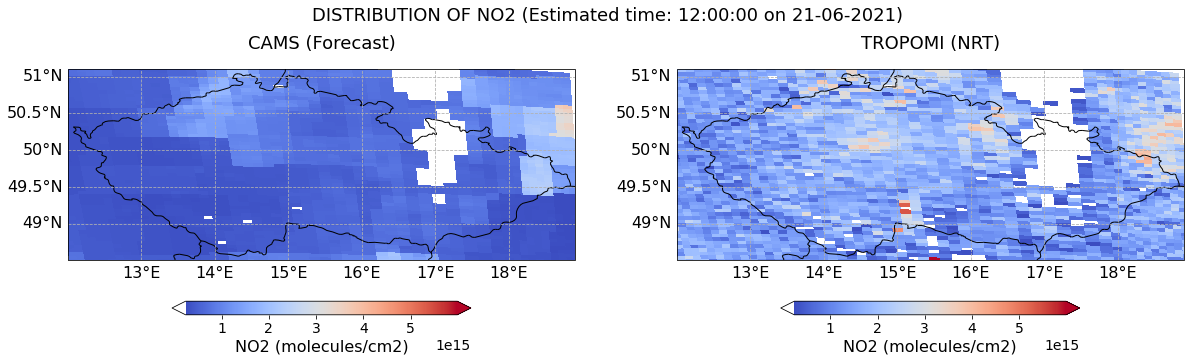

In [27]:
units = component_nom + ' (molecules/cm2)'
projection = ccrs.PlateCarree()

for t in range(TROPOMI.time.size):
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 5), subplot_kw = {'projection': projection})
    
    # Define vmin
    if (np.nanmin(TROPOMI.isel(time = t)) < np.nanmin(CAMS.isel(time = t))) and np.nanmin(TROPOMI.isel(time = t)) >= 0:
        vmin = np.nanmin(TROPOMI.isel(time = t))
    else:
        vmin = np.nanmin(CAMS.isel(time = t))
    
    # Define vmax
    if np.nanmax(TROPOMI.isel(time = t)) < np.nanmax(CAMS.isel(time = t)):
        vmax = np.nanmax(CAMS.isel(time = t))
    else:
        vmax = np.nanmax(TROPOMI.isel(time = t))

    # First plot - CAMS
    array = CAMS.isel(time = t)
    long_name = 'CAMS (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[0],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = vmin, 
                        vmax = vmax, 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    # Second plot - TROPOMI
    array = TROPOMI.isel(time = t)
    long_name = 'TROPOMI (NRT)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[1],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = vmin,  
                        vmax = vmax, 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    fig.suptitle(f'DISTRIBUTION OF {component_nom} (Estimated time: 12:00:00 on 21-06-2021)', 
                  fontsize = 18)
    plt.show()


## References
### Data sources
* CAMS global atmospheric composition forecasts (https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview)
* TROPOMI (https://s5phub.copernicus.eu/dhus)

### Background
* TROPOMI user manual (https://sentinels.copernicus.eu/documents/247904/3119978/Sentinel-5P-Level-2-Input-Output-Data-Definition)

### External functions
* Interpolation (http://christopherbull.com.au/python/scipy-interpolate-griddata/)
* Visualization function (https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/functions.ipynb)
* Mask NaN values (https://matplotlib.org/2.0.2/examples/pylab_examples/image_masked.html)
* Convert units (https://confluence.ecmwf.int/pages/viewpage.action?pageId=153391710)